In [203]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import miguel_tools as mt

In [204]:
data = Path("Lichun_2019-12-18_Time lapse_degree & speed.xlsx")
excel = pd.ExcelFile(data)
DFdegree = excel.parse('Degree', header=[0,1])
DFspeed = excel.parse('Speed', header=[0,1])

In [205]:
savein = data.parent / "Kolmogorov_results"
savein.mkdir(exist_ok=True)
# ksdegrees = savein / "degrees"
# ksspeed = savein / "speed"
# ksdegrees.mkdir(exist_ok=True)
# ksspeed.mkdir(exist_ok=True)

In [211]:
Set = 'speed'
DF = DFspeed
ph5mDegree = DF[['ph5 mutant']].droplevel(level=0, axis=1)
wtDegree = DF[['WT']].droplevel(level=0, axis=1)

timepoints = DF.iloc[:, :2].droplevel(level=0, axis=1)

ph5mDegree = pd.concat([timepoints, ph5mDegree], axis=1)
wtDegree = pd.concat([timepoints, wtDegree], axis=1)

ph5mDegreeM=ph5mDegree.melt(id_vars=['time point','time'],
    value_vars=ph5mDegree.columns.to_list()[2:],
    var_name='plantN',
    value_name=Set)

wtDegreeM=wtDegree.melt(id_vars=['time point','time'],
    value_vars=ph5mDegree.columns.to_list()[2:],
    var_name='plantN',
    value_name=Set)

ph5mDegreeM['cond'] = 'ph5 mutant'
wtDegreeM['cond'] = 'wild type'

Degreemelted = pd.concat([ph5mDegreeM, wtDegreeM])

Degreemelted.head()

,time point,time,plantN,speed,cond
0,0,13:49:00,plant 1,0.000052,ph5 mutant
1,1,14:09:00,plant 1,0.000120,ph5 mutant
2,2,14:29:00,plant 1,0.000028,ph5 mutant
3,3,14:49:00,plant 1,0.000075,ph5 mutant
4,4,15:09:00,plant 1,0.000017,ph5 mutant


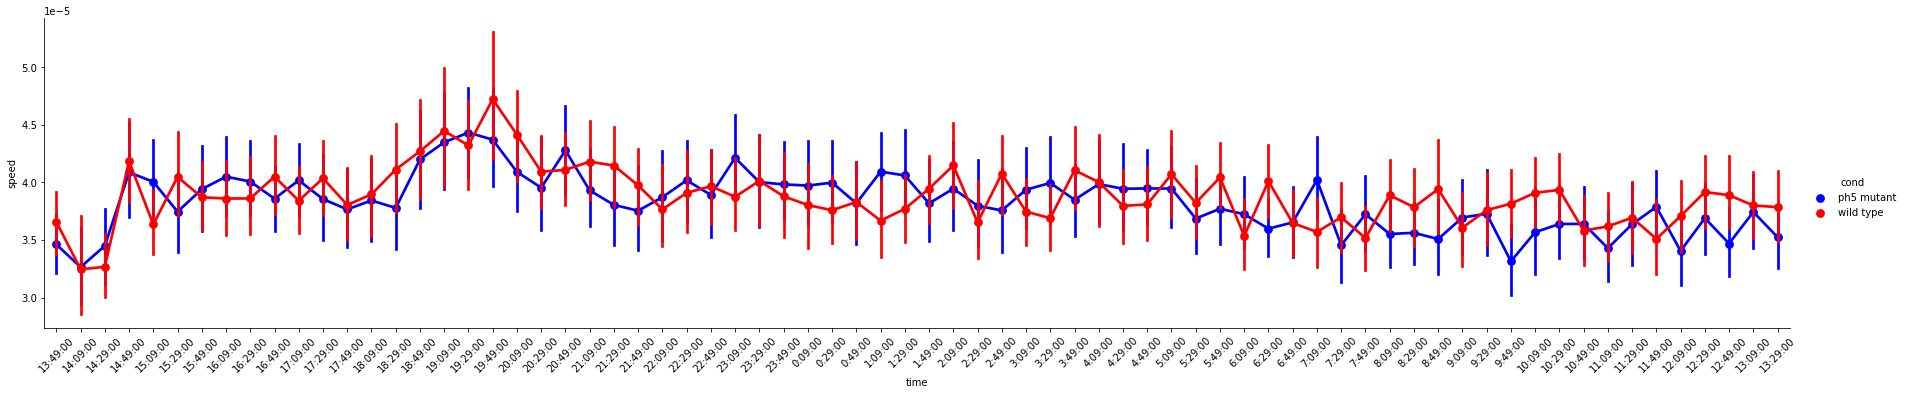

In [212]:
g = sns.catplot(kind='point', data=Degreemelted, y=Set, x='time', aspect=5, hue='cond', palette=sns.color_palette(['blue', 'red']))
g.set_xticklabels(rotation=45)
plt.savefig(savein / "{}_in_time.png".format(Set), dpi=300, bbox_inches='tight')

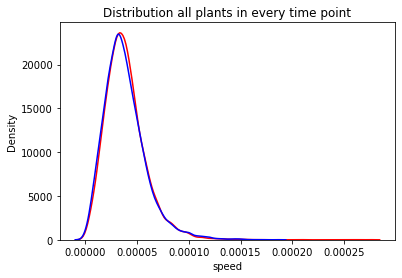

In [213]:
for name, group in Degreemelted[Degreemelted.cond == 'ph5 mutant'].groupby('time'):
    sns.kdeplot(group[Set], color='blue', )
    
for name, group in Degreemelted[Degreemelted.cond == 'wild type'].groupby('time'):
    sns.kdeplot(group[Set], color='red')


plt.title("Distribution all plants in every time point")
plt.savefig(savein / "{}_Distr_all.png".format(Set), dpi=300, bbox_inches='tight')
# plt.show()
plt.close()

sns.histplot(Degreemelted[Degreemelted.cond == 'wild type'][Set], color='red', stat='density', alpha=.5)
sns.histplot(Degreemelted[Degreemelted.cond == 'ph5 mutant'][Set], color='blue', stat='density', alpha=.5)
# plt.show()

plt.title("Distribution all plants in every time point")

plt.savefig(savein / "{}_Distr_all_hist.png".format(Set), dpi=300, bbox_inches='tight')
plt.close()

sns.kdeplot(Degreemelted[Degreemelted.cond == 'wild type'][Set], color='red', )
sns.kdeplot(Degreemelted[Degreemelted.cond == 'ph5 mutant'][Set], color='blue',)
plt.title("Distribution all plants in every time point")
plt.savefig(savein / "{}_Distr_all_density.png".format(Set), dpi=300, bbox_inches='tight')

In [214]:
d = defaultdict(list)
Sg = {False:"Significant", True:"No significant"}
alpha = 0.05

for name, group in Degreemelted.groupby('time'):
    mutant = group[group['cond'] == 'ph5 mutant'][Set]
    wt = group[group['cond'] == 'wild type'][Set]
#     ks = stats.ks_2samp(wt, mutant)
#     pv, st, sig = ks.pvalue, ks.statistic, ks.pvalue > alpha # FALSE -> Significative differents
    
    ad = stats.anderson_ksamp([wt, mutant])
    st, critical_values, pv, sig = ad.statistic, ad.critical_values, ad.significance_level, ad.significance_level > alpha
    
    d["time point"].append(name)
    d["p-value"].append(pv)
    d["stat"].append(st)
    d["significant"].append(Sg[sig])
    
    
#     sns.kdeplot(mutant, label='ph5 mutant')
#     sns.kdeplot(wt, label="wild type")
# #     plt.xlabel("degrees\n\n{}\n P-value: {} > {}\nStat: {}".format(Sg[sig], pv, alpha, st))
# #     plt.xlabel("speed\n\n{}\n P-value: {} > {}\nStat: {}".format(Sg[sig], pv, alpha, st))
#     plt.xlabel(name)
#     plt.legend()
#     plt.show()
#     plt.savefig(ksdegrees / "{}_{}_VS_{}.png".format(Sg[sig], p1, p2), dpi=300, bbox_inches='tight')
#     plt.savefig(ksspeed / "{}_{}_VS_{}.png".format(Sg[sig], p1, p2), dpi=300, bbox_inches='tight')
#     plt.close()
    
    
    
    
    
KSTest = pd.DataFrame(d)
KSTest.head()

<ipython-input-214-821b6fe4b612>:11: UserWarning: p-value capped: true value larger than 0.25
  ad = stats.anderson_ksamp([wt, mutant])


,time point,p-value,stat,significant
0,0:09:00,0.250000,-0.428906,No significant
1,0:29:00,0.250000,-0.367262,No significant
2,0:49:00,0.250000,-0.749803,No significant
3,10:09:00,0.026700,2.651460,Significant
4,10:29:00,0.052453,1.921456,No significant


In [215]:
# KSTest[KSTest.significant == 'Significant']
mt.writting_excel(KSTest, pathname=savein / "AD_Result_{}.xlsx".format(Set))

In [216]:
# sns.kdeplot(data=Degreemelted[Degreemelted['cond'] == 'ph5 mutant'], x='time point', y='degree', color='blue')
# sns.kdeplot(data=Degreemelted[Degreemelted['cond'] == 'wild type'], x='time point', y='degree', color='red', )

In [188]:
ph5mDegreeAVG = pd.concat([timepoints, ph5mDegree.T.describe().T], axis=1)
wtDegreeAVG = pd.concat([timepoints, wtDegree.T.describe().T], axis=1)

In [189]:
wtDegreeAVG.head()

,time point,time,count,unique,top,freq
0,0,13:49:00,29.0,28.0,0.000039,2.0
1,1,14:09:00,29,29,1,1
2,2,14:29:00,29.0,29.0,0.000041,1.0
3,3,14:49:00,29.0,29.0,0.000041,1.0
4,4,15:09:00,29.0,27.0,0.000026,2.0


In [190]:
# sns.lineplot(data=wtDegreeAVG, x='time point', y='mean')
# sns.lineplot(data=wtDegreeAVG, x='time point', y='std')

In [27]:
# DFdegree_melted = DFdegree.melt(id_vars=['time point', 'time'],
#     value_vars=DFdegree.columns.to_list()[2:],
#     var_name='plantN',
#     value_name='degree')

In [28]:
# DFdegree_melted.head()

In [26]:
# sns.displot(data=DFdegree_melted, x="degree", hue="plantN", kind="kde")

In [106]:
from itertools import combinations
plants = DFdegree.columns.to_list()[2:]
plantsComb = list(combinations(plants, 2))
len(plantsComb)

1035

In [105]:
from scipy import stats
from collections import defaultdict

In [113]:
d = defaultdict(list)
Sg = {False:"Significant", True:"No significant"}
alpha = 0.05

for ix in range(len(plantsComb)):
    p1, p2 = plantsComb[ix]
    d['plant A'].append(p1)
    d['plant B'].append(p2)
    
#     DF1, DF2 = DFdegree[p1], DFdegree[p2]
    DF1, DF2 = DFspeed[p1], DFspeed[p2]
    ks = stats.ks_2samp(DF1, DF2)
    pv, st, sig = ks.pvalue, ks.statistic, ks.pvalue > alpha # FALSE -> Significative differents
    d['Sig'].append(Sg[sig])
    d['P-value'].append(pv)
    d['Statistic'].append(st)
    
#     if sig == True:
    sns.kdeplot(DF1, label=p1)
    sns.kdeplot(DF2, label=p2)
#     plt.xlabel("degrees\n\n{}\n P-value: {} > {}\nStat: {}".format(Sg[sig], pv, alpha, st))
    plt.xlabel("speed\n\n{}\n P-value: {} > {}\nStat: {}".format(Sg[sig], pv, alpha, st))
    plt.legend()
#     plt.savefig(ksdegrees / "{}_{}_VS_{}.png".format(Sg[sig], p1, p2), dpi=300, bbox_inches='tight')
    plt.savefig(ksspeed / "{}_{}_VS_{}.png".format(Sg[sig], p1, p2), dpi=300, bbox_inches='tight')
    plt.close()
#     plt.show()

In [116]:
import miguel_tools as mt
Ks_result = pd.DataFrame(d)

display(Ks_result)
# mt.writting_excel(Ks_result, pathname=savein / "KS_Result_degrees.xlsx")
# mt.writting_excel(Ks_result, pathname=savein / "KS_Result_speed.xlsx")

,plant A,plant B,Sig,P-value,Statistic
0,plant 1,plant 2,Significant,6.933597e-05,0.142292
1,plant 1,plant 3,No significant,1.336656e-01,0.073123
2,plant 1,plant 4,Significant,3.651036e-02,0.088933
3,plant 1,plant 5,Significant,1.415719e-54,0.486166
4,plant 1,plant 6,Significant,6.964609e-09,0.195652
...,...,...,...,...,...
1030,plant 24,plant 26,Significant,4.041912e-03,0.110672
1031,plant 24,plant 27,Significant,1.425377e-02,0.098814
1032,plant 25,plant 26,No significant,7.212277e-02,0.081028
1033,plant 25,plant 27,Significant,9.212917e-05,0.140316
